# Regression and Goodness of the fit


**Course: "Introduction to data analysis methods for HEP"**

*Author: Jose A. Hernando*, January 2017

*Particle Physics Deparment. Universidade de Santiago de Compostela, Spain.*

These is a series of lectures on Data Analysis for High Energy Physics. Emphasis is put on Hypothesis testing and Confidence Intervals. They are based on the excellent lectures on statistics by Prosper [1], Cowan [2] and Cranmer[3] given at CERN Academic Training.

The most common data analysis packages in HEP are ROOT, RooFit and TMVA [9]. But we will use the Python scientic toolkits, Matplotlib, Numpy, Scipy, Scikit-learn [10] that comes with the Anaconda Python distribution [10]. 

Structure of the course:
* General Concepts: probability density functions and likelihoods. Frequentist and bayesian statistics
* Hypothesis testings: test statistic. Continuous hypothesis. CLs method.
* Confidence Interval: Classical and F.C. intervals.
* MVA: Classification and Regression
* Regression: Likelihood estimation.


Structure of the chapter:
* Introduction
* Estimator of the mean and variance
* Maximun Likelihood
* Least Squares
* Goodness of the fit: chi squares, kolmogoriv-smirnov test
* Goodness of the fit mutivariate: nearest neighbors, energy and kernel methods

In [70]:
# general imports
%matplotlib inline

# numpy and matplotlib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

# possible styles: ggplot (simplicity), bmh (scientify data), 
matplotlib.style.use('ggplot')

# ploting images
from IPython.display import display, Image

In [71]:
import time

print ' Last Execution ', time.asctime()

 Last Execution  Mon Feb 13 15:32:54 2017


----

## Introduction

**regression** is the task of estimating the parameters of a model using data.
For exmaple, an experiment measures a sparse events that are poisson distributed, $f(n |\nu)$ what is the best estimate of $\nu$? The most common regression methods are the Least Squares (LS) and the Maximum Likelihood (ML).

**goodness of the fit** is the task to quantify the agreement between two datasets, or a dataset and a model. A typical example is to check if the model obtained by regression is consistent with the original dataset. Another example: consider an experiment that measures two datasets, they should be identicial if they were taken with the same conditions, otherwise there is systematic error. Other example, if a conservation or symmetry law in Physics will preserve the distributions of two datasets, but we observe they are not identical, then, there is a violation of physics! The most common goodness of the fit used are the $\chi^2$ and the Kolmogorov-Smirnov. The later is only valid in 1D problems. Extending goodness of the fit to multivariate datasets is not simple, and not settled.


## Estimators

We call an estimator a method to estimate the value of a parameter, $\hat{\mu}$, using the data $x$, where the true parameter is $\mu$. An estimator is optimal if:

* there is not bias in the average of $\hat{\mu}$, that is,  $ E[\hat{\mu}]-\mu = 0,$. The mean of the distribution of $\hat{\mu}$ is the true value, $\mu$. 
* it has the smallest variance: $V[\hat{\theta}]$. 

We expect that with a larger sample, the variance will decrease!

### Estimators of the mean and the variance


The estimator of the mean of a data set with $n$ samples of a measurement $x$, distributed with a given pdf, $f(x |\mu)$, is:
$$
\hat{\mu} = \frac{1}{n} \sum_{i=1}^n x_i
$$
and its variance
$$
V[\hat{\mu}] = \frac{\sigma^2}{n}
$$
were $\sigma^2$ is the variance of the x, $V[x]$.

The estimator of the variance, $\sigma^2$, $V[x]$, of $n$ samples of $x$ measurements, distributed with a pdf $f(x | \mu)$ is:
$$
\hat{\sigma}^2 = \frac{1}{n-1} \sum_{i=1}^n (x_i - \hat{\mu})^2
$$
and its variance:
$$
V[\hat{\sigma}^2] = \frac{1}{n} \left( \mu_4 - \frac{n-3}{n-1} \mu_2 \right),
$$
where:
$$
\mu_n = \int (x-\mu)^k \, f(x |\mu) \mathrm{d}x
$$
It is not bias, $E[\hat{\sigma}^2-\sigma^2]=0$ and it is optimal.


**Example** Generate $m$ datasets, each one of $n$ samples of $x$, expected to be normal distributed. Obtain the distribution of its mean and variance. Check that the estimators are not biased. Verify that the estimator of the variance is not bias using a small value of $n$ samples.

 E[mu] =  1.00, mu-true  1.00
 E[var] =  4.00, sigma-true  2.00 


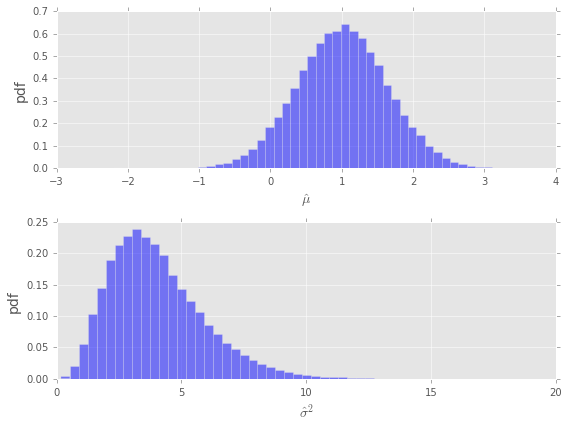

In [3]:
mu, sigma = 1., 2.
m, n = 100000, 4
xs = [stats.norm.rvs(mu, sigma, size=10) for i in range(m)]
xhats = np.array([np.mean(xis) for xis in xs])

def var(xs, xhat):
    dx = (xs-xhat)
    n = 1.*len(xs)
    return np.sum(dx*dx)/(n-1)

xsigs = np.array([var(xis, xihat) for xis, xihat in zip(xs, xhats)])
print ' E[mu] = {:5.2f}, mu-true {:5.2f}'.format(np.mean(xhats), mu)
print ' E[var] = {:5.2f}, sigma-true {:5.2f} '.format(np.mean(xsigs), sigma)

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax0, ax1 = axs.ravel()

ax0.hist(xhats, bins=50, normed=True, color='blue', alpha=0.5)
ax0.set_xlabel(r'$\hat{\mu}$', fontsize=14)
ax0.set_ylabel('pdf', fontsize=14)

ax1.hist(xsigs, bins=50, normed=True, color='blue', alpha=0.5)
ax1.set_xlabel(r'$\hat{\sigma}^2$', fontsize=14)
ax1.set_ylabel('pdf', fontsize=14)

fig.tight_layout()
fig.savefig('figs/re_estimators.png');

## Maximum likelihood estimator (MLE)

The likelihood is the evaluation of the probability at the $x$ data. if $x$ is a list of independent measurements, the likelihood is the product of the individual likelihoods (also called **joint likelihood**).

$$
\mathcal{L}(\mu) = f(x | \mu) = \Pi_{i=1}^n f(x_i|\mu)
$$

Usually this is small number, so, it is natural to take the logarithm, and call about the log-likelihood function: 

$$
\log f(x | \mu).
$$

Given a set of measurements $\{x\}$, the maximum likelihood estimators are those one that maximizes the likelihood function. The estimators are very good, but not always optimal! They can be bias!

The second degree Taylor's expansion around the $\hat{\mu}$ is:
$$
\log \mathcal{L} (\mu) \simeq \log \mathcal{L}(\hat{\mu}) + \frac{\partial \log \mathcal{L}(\mu}{\partial \mu} (\mu-\hat{\mu})+ \frac{1}{2!}  \frac{\partial^2 \log \mathcal{L}(\mu)}{\partial \mu^2} (\mu-\hat{\mu})^2
$$

The variance is:
$$
\sigma^2_{\hat{\mu}} = - \left[\frac{\partial^2 \log \mathcal{L}(\mu)}{\partial \mu^2}\right]^{-1}_{\hat{\mu}}
$$

we have:

$$
\log \mathcal{L} (\hat{\mu} \pm \sigma_{\hat{\mu}} )= \log \mathcal{L}(\hat{\mu}) - \frac{1}{2}.
$$

We use instead, $-2 \log \mathcal{L}(\mu)$. The a standar desviation is now related with the increase in one unit in $-2 \log \mathcal{L}(\mu)$ respect the value at the best estimate, $\hat{\mu}$:

$$
-2 \log \frac{\mathcal{L}(\hat{\mu}\pm \sigma_{\hat{\mu}})}{ \mathcal{L}(\hat{\mu})} = 1
$$

Unfortunately the LL is not a good criteria for the goodness of the fit! We need to use other methods (see section net). 

**Exercise:** Consider the decay of a particle with $\tau = 1$, generate a dataset with $n$ decays and its time measurements $x_i, \, i=1, \dots, n$. Compute $\hat{\tau}$ using the MLE. Use the scan in $\log \mathcal{L} (\tau)$ to estimate the variance of $\tau$. Generate $m$ datasets with $n$ decays each one, obtain the distribution of $\hat{\tau}$, its mean and variance. 

First notice, that the MLE for an exponential is just the mean:

$$
f(x \ | \tau) = \frac{1}{\tau^n} \Pi_{i=1}^n e^{-x_i/\tau}
$$

$$
-2 \log \mathcal{L}(\tau) = 2 n \log(\tau) + 2 \sum_{i=1}^n \frac{x_i}{\tau}
$$

$$
\hat{\tau} = \frac{1}{n} \sum_{i=1}^n x_i
$$

E[tau] =  1.00
E[sigma_tau] =  0.40


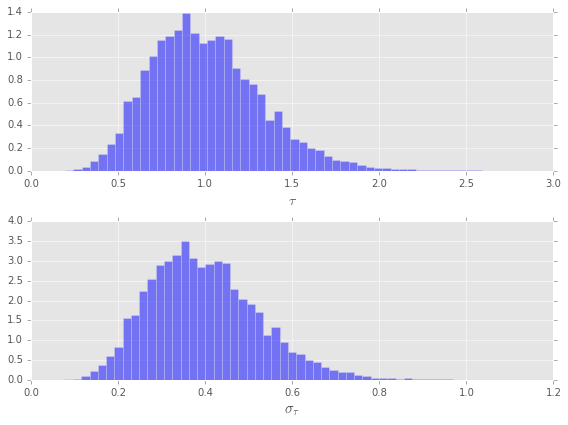

In [4]:
import scipy.optimize as optimize

m, n = 10000, 10
tau = 1.

xs = [stats.expon.rvs(scale=tau, size=n) for i in range(m)]

def ll(xs, tau):
    return 2.*np.sum(xs)/tau + 2.*len(xs)*np.log(tau) 

def muhat(xs):
    return np.mean(xs)

def tmu(xs, mu):
    mhat = muhat(xs)
    return ll(xs, mu) - ll(xs, mhat)

def fun_root(xs, delta=0.):
    def fun(mu):
        return tmu(xs, mu) - delta 
    return fun

def sigmas(xs, nsize=3.):
    muhat0 = muhat(xs)
    xfun = fun_root(xs, delta=1.)
    # xl = optimize.brentq(xfun, 0., muhat0)
    xu = optimize.brentq(xfun, muhat0, nsize*muhat0)
    return xu-muhat0


taus = np.array([np.mean(xis) for xis in xs])
sigs = np.array([sigmas(xis) for xis in xs])

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax0, ax1 = axs.ravel()

ax0.hist(taus, bins=50, normed=True, color='blue', alpha=0.5);
ax0.set_xlabel(r'$\tau$', fontsize=14)

ax1.hist(sigs, bins=50, normed=True, color='blue', alpha=0.5);
ax1.set_xlabel(r'$\sigma_\tau$', fontsize=15)

print 'E[tau] = {:5.2f}'.format(np.mean(taus))
print 'E[sigma_tau] = {:5.2f}'.format(np.mean(sigs))

fig.tight_layout();


### Binned Maximum Likelihood

When data is into a histogram (with bins $x_i$ and contents $n_i$, with $i=1, \dots, n$), the miximum likelihood is said to be binned. There is some loss of information passing from unbin to bin ML, but if the number of samples is very large, the binned ML reduces the computational time.

In the case of the histogram:
$$
- 2 \log \mathcal{L}(\mu) = -2 \sum_{i=1}^n n_i \log f(x_i | \mu)
$$


**Example:** Fill a histogram with $n$ samples of a measurement $x$ distributed with an exponential with $\tau=1$. Obtain $\hat{\tau}$ with a binned ML.

best estimate tau 0.967


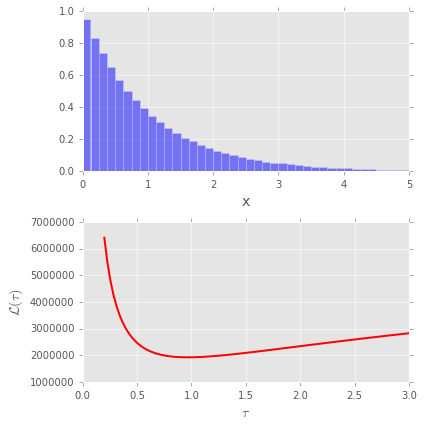

In [26]:
tau = 1.
n = 1000000
xss = stats.expon.rvs(size=n, scale=tau)

ns, xedges = np.histogram(xss, bins=40, range=(0., 5.))
xs = 0.5*(xedges[1:]+xedges[:-1])

def ll(xtau, xs, ns):
    return -2*np.sum(ns*np.log(stats.expon.pdf(xs, scale=xtau)))

def llfun(xs, ns):
    def fun(xtau):
        return ll(xtau, xs, ns)
    return fun

def muhat(xtau0, xs, ns):
    fun = llfun(xs, ns)
    result = optimize.minimize(fun, x0=xtau0, method='Nelder-Mead')
    return result.x[0]

fig, axs = plt.subplots(2, 1, figsize=(6, 6))
ax0, ax1 = axs.ravel()

ax0.hist(xss, bins=40, normed=True, range=(0., 5.), color='blue', alpha=0.5);
ax0.set_xlabel(r'x', fontsize=14)

taus = np.linspace(0.2, 3., 100)
lls = np.array([ll(itau, xs, ns) for itau in taus])
ax1.plot(taus, lls, color='red', lw=2)
ax1.set_xlabel(r'$\tau$', fontsize=14)
ax1.set_ylabel(r'$\mathcal{L}(\tau)$', fontsize=14)

fig.tight_layout()

tauhat = muhat(2., xs, ns)
print 'best estimate tau {:5.3f}'.format(tauhat)


### Extended Maximum Likelihood

Consider the case of $n$ samples of $x$ measurements, distributed with a pdf $f(x | \mu)$, and $n$ is itself poisson distributed $f(n | \nu)$. The complete likelihood is:

$$
\mathcal{L}(\nu,\mu) = \frac{\nu^n}{n!} e^{-\nu} \Pi_{i=1}^n f(x_i|\mu)
$$

And it is called **Extended Maximum Likelihood function**. In the cases where $\nu$ depends on $\mu$, for example, we should using the EML. If $\nu$ is independent of $\mu$, then $\hat{\nu} = n$, and we recover the ML result.


#### Signal and background samples combined

Consider two types of samples, background and signal, each one has a given pdf in one variable $x$, $f_b(x | \mu), f_s(x | \mu')$. We measure $n$ samples of $x$, with a unknown number of signal and background events, but we expect them distributed with a poisson with means $\nu_s, \, \nu_b$. The pdf of the variable $x$, $f(x| \nu_s, \nu_b, \mu, \mu')$ is the product of two pdfs: 

The pdf for $x$:
$$
f(x|\nu_s,\nu_s, \mu, \mu') = \frac{\nu_s}{\nu_s+\nu_b} f_s(x | \mu) + \frac{\nu_b}{\nu_s+\nu_b} f_b(x | \mu')
$$
And pdf of the number of events, that is poisson distributed:
$$
p(n|\nu_s,\nu_b) = \frac{(\nu_s+\nu_b)^n}{n!} e^{-(\nu_s+\nu_b)}
$$

The complete pdf is:
$$
f(n, x | \nu_s,\nu_b, \mu, \mu') = p(n|\nu_s,\nu_b) \, f(x|\nu_S,\nu_B, \mu, \mu')
$$

**Exercise:** Consider a dataset with $n$ samples of a measuremnet $x$. The samples can be either background or signal. For the background $x$ follows and exponential and for the signal a gaussian. Use EML to compute the number of signal and background events in the dataset.

 true: signal = 16, bkg = 98
 minimize:  True
 best : signal = 16.72, bkg = 97.28 


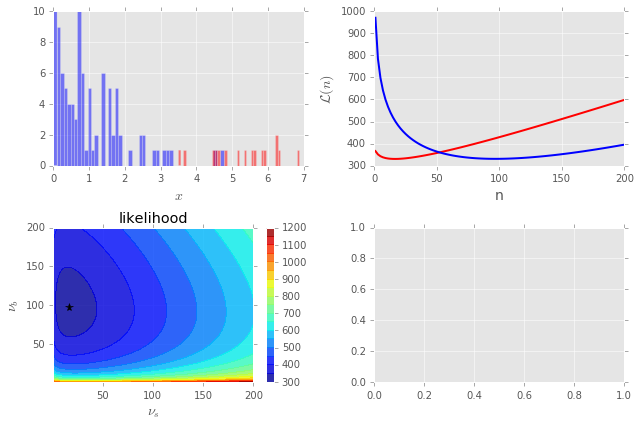

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as optimize

nus, nub = 20, 100
tau = 1
mu, sigma = 5, 1

# code
def ll(xs, mus):
    nus, nub = float(mus[0]), float(mus[1])
    nu = nus+nub
    if (float(nu)<=0.):
        return 1.e33
    q = nus/nu
    n = len(xs)
    pn = stats.poisson.pmf(n, nu)
    pb = stats.expon.pdf(xs, scale=tau)
    ps = stats.norm.pdf(xs, scale=sigma, loc=mu)
    xll = -2.*np.sum(np.log((1-q)*pb+q*ps))-2*np.log(pn)
    return xll

def llfun(xnus, xnub):
    return ll(xs, (xnus, xnub))

def minllfun(xx):
    return ll(xs, xx)

# generate samples
ns = stats.poisson.rvs(nus, size=1)[0]
nb = stats.poisson.rvs(nub, size=1)[0]
bxs = stats.expon.rvs(scale=tau, size=nb)
sxs = stats.norm.rvs(scale=sigma, loc=mu, size=ns)
print ' true: signal = {:d}, bkg = {:d}'.format(ns, nb)

# generate combined sample and shuffle it!
xs = np.array(list(sxs)+list(bxs))
np.random.shuffle(xs)

# get the best estimates of nus and nub
result = optimize.minimize(minllfun, x0=(100., 100.), 
                           method='Nelder-Mead')
print ' minimize: ', result.success
nushat, nubhat = result.x[0], result.x[1]
print ' best : signal = {:5.2f}, bkg = {:5.2f} '.format(nushat, nubhat)


# plots
fig, axs = plt.subplots(2, 2, figsize=(9, 6))
ax0, ax1, ax2, ax3 = axs.ravel()

ax0.hist(bxs, bins=50, color='blue', alpha=0.5, label='bkg')
ax0.hist(sxs, bins=50, color='red', alpha=0.5, label='sig')
ax0.set_xlabel(r'$x$', fontsize=14)
ax1.set_ylabel('samples', fontsize=14)

bins = max(nus, nub)
xnus = np.linspace(1., 2.*bins, 100)
llss = np.array([ll(xs, (nui, nub)) for nui in xnus])
llbs = np.array([ll(xs, (nus, nui)) for nui in xnus])
ax1.plot(xnus, llss, color='red', lw=2, label='signal')
ax1.plot(xnus, llbs, color='blue', lw=2, label='bkg');
ax1.set_xlabel('n', fontsize=14)
ax1.set_ylabel(r'$\mathcal{L}(n)$', fontsize=14)

xnus = np.linspace(1., 2.*bins, 100)
ynus = np.linspace(1., 2.*bins, 100)
mxnus, mynus = np.meshgrid(xnus, ynus)
zz = [[llfun(inus, inub) for inus in xnus] for inub in ynus]
zz = np.array(zz)
c0 = ax2.contourf(mxnus, mynus, zz, 20, alpha=0.8, 
                 cmp=plt.cm.jet)
ax2.set_xlabel(r'$\nu_s$', fontsize=14)
ax2.set_ylabel(r'$\nu_b$', fontsize=14)
ax2.plot(nushat, nubhat, color='black', 
         marker='*', markersize=8)
ax2.set_title('likelihood')
fig.colorbar(c0, ax=ax2)

fig.tight_layout();

## Least squared method

Consider a dataset of $n$ pair samples $\{(x_i, \, y_i)\}$, where $i=1,\dots,n$. There is a relation between $y$ and $x$, given by a model $y=\lambda(x|\mu)$, that depends on a parameter $\mu$.  If the $y_i$ measurements are gaussian distributed with known variances $V[y_i] = \sigma^2_i$. The likelihood function for this data set is:

$$
\mathcal{L} (\mu) = \Pi_{i=1}^n \frac{1}{\sqrt{2\pi}\sigma_i} e^{- \frac{(y_i-\lambda(x_i|\mu))^2}{2\sigma^2_i}}
$$

If we take the logarithm and remove the constant terms, those ones that do not depend on $\mu$, we get:

$$
-  2 \log \mathcal{L}(\mu) = \sum_{i=1}^n \frac{(y_i - \lambda(x_i|\mu))^2} { \sigma^2_i}
$$
that is the $\chi^2$.

Maximizing $\log \mathcal{L} (\mu)$ is now the same as minimizing  the $\chi^2 (\mu)$.

$$
\chi^2(\mu) = - 2 \log \mathcal{L} (\mu)
$$

The best estimate, $\hat{\mu}$, is the minimum of the $\chi^2$. The variance of $\hat{\mu}$ is:

$$
\sigma^2_{\hat{\mu}} \simeq 2 \left[ \frac{\partial^2 \chi^2}{\partial \mu^2}\right]^{-1}_{\hat{\mu}}
$$

or where the expansion of $\chi^2$ around the minimum gets increased by one.

$$
\chi^2(\hat \mu \pm \sigma_{\hat \mu}) = \chi^2(\hat \mu) + 1
$$

### goodness of the fit

The least squares method provides a criteria to estimate the goodness of the fit. The variable $\chi^2$ follows a $\chi^2$ distribution with $n$ degrees of freedom (the measurements minus the number of parameters), $\chi^2(t|n)$. Therefore it can be used as a test statistics to compute a $p$-value of a $\chi^2$!

$$
p = \int_{\chi^2}^{\infty} \chi^2(t|n) \, \mathrm{d}t
$$



**Exercise:** Consider a linear dependence $y=ax+b$, where $a,b$ are parameters ($a=1, \, b=0$). Generate an dataset with $n=4$ pairs of measurements $\{(x_i,y_i)\}$, with $i=1,\dots,n$; and a variance on $y$ of $\sigma^2_y = 0.1$. Estimate the $a,b$ parameters using LS. Compute the $\chi^2$ and the $p$-value. Generate now $m$, large number, datasets, and get he $\chi^2$ distribution, check that it follows a $\chi^2_n(t|n=2)$  distribution. Get also the pull distributions for $a, b$. Are they gaussian distributed with mean zero and sigma one?

In [28]:
def ls_chi2(result):
    """ it computes the chi2 and cov matrix from the result of a least_squares scipy fit
    return the chi2/ndf
    result is updated with the information of the chi2, and the cov matrix!
    """
    chi2 = np.sum(result.fun**2)
    ndf = float(len(result.fun)-len(result.x))
    chi2ndf = chi2/ndf
    cov = (np.linalg.inv(np.dot(result.jac.T, result.jac)))*chi2ndf
    result.chi2 = chi2
    result.ndf = ndf
    result.cov = cov
    return chi2/ndf
    

 pull a  0.0137602424163  sigma  1.14768704629
 pull b  0.00915901037825  sigma  1.16455268833


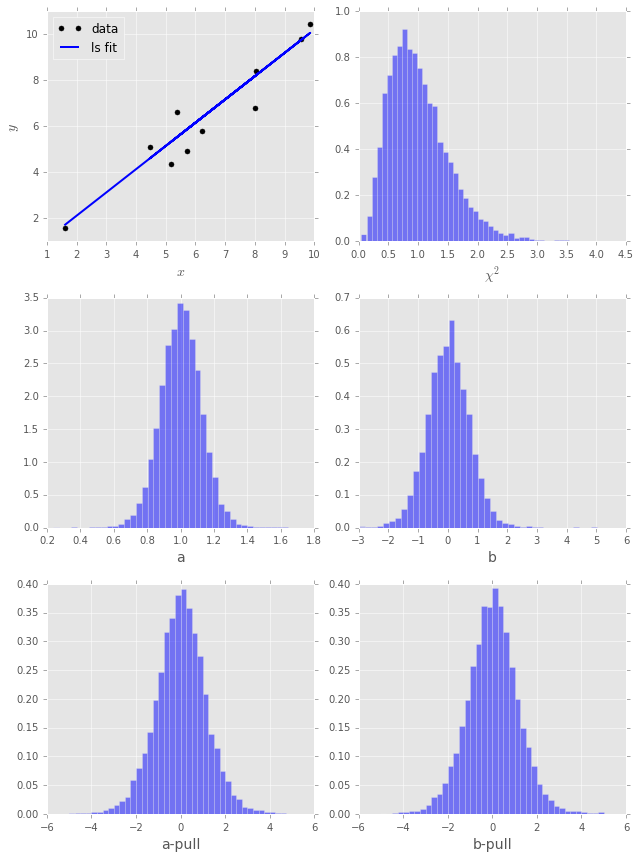

In [35]:
import scipy.optimize as optimize

a, b = 1., 0.
sigma = 1.
m, n = 10000, 10
xsize = 10.
nbins = 40

def experiment(n):
    xs = xsize*stats.uniform.rvs(size=n)
    ys = a*xs+b+stats.norm.rvs(scale=sigma, size=n)
    return (xs, ys)

xs = [experiment(n) for i in range(m)]

def resfun(xs, ys, errors):
    def fun(pars):
        dx = (ys-pars[0]*xs+pars[1])/errors
        return dx
    return fun

def ls(xi, x0):
    xs, ys = xi[0], xi[1]
    lsfun = resfun(xs, ys, sigma)
    result = optimize.least_squares(lsfun, x0=x0)
    chi2 = ls_chi2(result)
    a, sigma_a = result.x[0], np.sqrt(result.cov[0, 0])
    b, sigma_b = result.x[1], np.sqrt(result.cov[1, 1])
    return (chi2, a, b, sigma_a, sigma_b)

x0 = [a, b]
lsvals = [ls(xi, x0) for xi in xs]

fig, axs = plt.subplots(3, 2, figsize=(9 , 12))
ax0, ax1, ax2, ax3, ax4, ax5 = axs.ravel()

xxs, ys = xs[0][0], xs[0][1]
ax0.plot(xxs, ys, color='black', marker='o', markersize=5, 
         ls='none', label='data')
a0, b0 = lsvals[0][1], lsvals[0][2]
ax0.plot(xxs, a0*xxs+b0, color='blue', lw=2, label='ls fit')
ax0.legend(loc=2)
ax0.set_xlabel(r'$x$', fontsize=14)
ax0.set_ylabel(r'$y$', fontsize=14)

chi2 = [xi[0] for xi in lsvals]
ax1.hist(chi2, bins=50, normed=True, color='blue', alpha=0.5)
ax1.set_xlabel(r'$\chi^2$', fontsize=14)

xas = np.array([xi[1] for xi in lsvals])
xsas = np.array([xi[3] for xi in lsvals])
ax2.hist(xas, bins=nbins, normed=True, color='blue', alpha=0.5)
ax2.set_xlabel('a', fontsize=14)

xbs = np.array([xi[2] for xi in lsvals])
xsbs = np.array([xi[4] for xi in lsvals])
ax3.hist(xbs, bins=nbins, normed=True, color='blue', alpha=0.5)
ax3.set_xlabel('b', fontsize=14)

aps = (xas-a)/xsas
print ' pull a ', np.mean(aps), ' sigma ', np.std(aps)
ax4.hist(aps, bins=nbins, normed=True, range=(-5., 5.), 
         color='blue', alpha=0.5)
ax4.set_xlabel('a-pull', fontsize=14)

bps = (xbs-b)/xsbs
print ' pull b ', np.mean(bps), ' sigma ', np.std(bps)
print np.describe(bps)
ax5.hist(bps, bins=nbins, normed=True, range=(-5., 5.),
         color='blue', alpha=0.5)
ax5.set_xlabel('b-pull', fontsize=14);

fig.tight_layout()

## Goodness of the fit

How to know is two samples come from the same pdf? Are they identical? What is its goodness of the fit?

To check the goodness of the fit we require a model and a test dataset. As we do for hypothesis testing, we need to define a test-statistics that quantifies the agreement of the test with the model. 

### p-values

(See chapter on Hypothesis testing)

The p-value measures the probability of obtaining a measurement equal or less compatible than the current dataset compatible with the model, $H_0$. For first, define a test statistics, $t(x)$, to be computed from a dataset $x$. Usually low values of $t(x)$ indicates compatibility with $H_0$ and larger values worse compatibility. To compute the p-value we need to know the pdf of the test statistics: $f(t|H_0)$ 

From the test-statistic of the test dataset, $t_0$, we determine the p-value of the test:
$$
\alpha = \int_{t_0}^{\infty} f(t | H_0) \mathrm{d}t
$$
where $\alpha$, is the p-value.

If our dataset follows a hypothesis $H_0$, the p-values are uniform distributed between [0, 1]. If the p-value of our observation is low, i.e. 1%, then can conclude that we have a bad agreement with the model. In general if $p < 0.05 \, (0.1)$ we exclude that the test dataset comes from $H_0$ at 95% (90%) CL. (see confidence level chapter)

**Exercise:** Generate an experiment with $n$ samples normal distributed. Compute its $p$-value. What happens if you were considering that the model was a gaussian with mean 3 and sigma 1?


### $\chi^2$ test

Consider the case of a model $H_0$, that predicts a set of measurements ${\bf x}'$, with a covariance matrix ${\bf V}$. The actual measurements are ${\bf x}$. The $\chi^2$ quantifies the agreement between the measurments and the predictions. In matricial form:

$$
\chi^2 = ({\bf x} - {\bf x}') \, {\bf V} \, ({\bf x} - {\bf x}')^t
$$

The $\chi^2$ is distributed with a $\chi^2(t | n)$ distribution of $n$ degrees of freedom, where $n$ is the number of measurements minus the number of parameters of our model that we have estimated from the data. 

We can use that we know the pdf of $\chi^2$ to compute its p-value:

$$
\alpha = \int_{\chi^2}^{\infty} \chi^2(t | n) \mathrm{d} t
$$

This is the test we use to quantify the goodness of the a least squares fit! (see section)

**Exercise:** Generate $n$ measurements according with a polinomial model $y = f(x)$ with equal error, $\sigma$, for each measurement. Compute the $\chi^2$ distribution.

### Kolmogorov-Smirnov test


The KS test cuantifies measured the largest desviation of the cumulative of the test dataset with respect the cumulative of the model. The model can be also a second dataset!

The test only works on one dimension!


**Exercise:** Generate a datasets with $n$ samples of $x$, that is normal distributed. Do a KS test with respect the normal distribution. Repeat the test with respect a gaussian model of mean 3 and sigma 1.

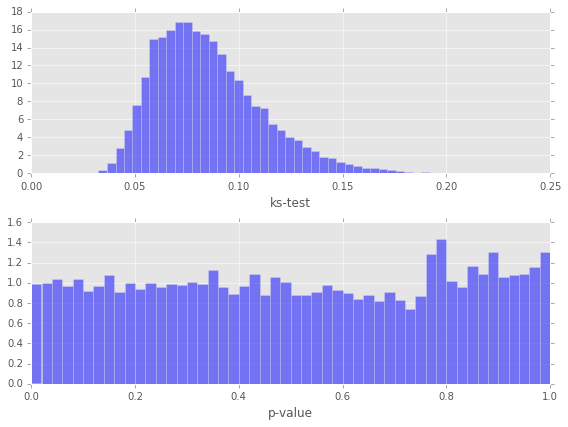

In [53]:
m, n = 10000, 100
mu0, mu1 = 0., 0.
sig0, sig1 = 1., 1.

h0 = stats.norm(loc=mu0, scale=sig0)
h1 = stats.norm(loc=mu1, scale=sig1)

def experiment(n):
    return h1.rvs(size=n)

sets = [experiment(n) for i in range(m)]

ksvals = [stats.kstest(iset, h0.cdf) for iset in sets]

kss = np.array([val[0] for val in ksvals])
pss = np.array([val[1] for val in ksvals])

fig, axs = plt.subplots(2, 1, figsize=(9, 6))

ax0, ax1 = axs.ravel()

ax0.hist(kss, bins=50, normed=True, color='blue', alpha=0.5)
ax0.set_xlabel('ks-test')

ax1.hist(pss, bins=50, normed=True, color='blue', alpha=0.5)
ax1.set_xlabel('p-value')

fig.tight_layout();

## n-dimensional goodness of the fit tests

Testing the goodness of the fit for n-dimensional models or dataset is more complex. First, the KS test is only valid in 1D. To continue, often it is not possible to use the $\chi^2$ test. In addition, many times, we do not know the pdf of the model. Again moving to many dimensions, one faces the *curse of dimensionality*! In general in $n$ dimensions, we have two datasets and we are left with the questions if they come from the same pdf, model!

There is no unique method or best method in a n-dimensional goodness of the test. The following methods, k nearest neighbor, energy test are used in HEP. (see ref [8])


### k nearest neighbour

There is a collection of methods to test the goodness of the fit that are based in mixing the datasets.
Consider the case where we have two datasets. If both they come from the same model, mixing them, will generate another dataset from the same model. 

The k-nearest neighbour, is based on a test-statistic, that measures the average fraction of neighbor points of the same dataset with respect every point, from the mix of the two original datasets. To do so, first, we need to define the distance between two points, ${\bf x}_i, \ {\bf x}_j$, in the $n$ dimensional space. The euclidian distance is a natural possibility.

$$
| {\bf x}_i - {\bf x}_j |^2 = \sum_{k=i}^n \left( \frac{x^k_i-x^k_j}{w^k}\right)^2 
$$

where $k$ is the index in the dimension of the space. For the euclidian distance with all coordinates equal, we take the weight $w^k =1$.

The test statistics, $t$, is then computed from the average number of points from the same dataset with respect any point in the pooled sample.

$$
t = \frac{1}{n_a+n_b} \sum_{i=1}^{n_a+n_b} \frac{1}{n_k} \sum_{k=1}^{n_k} I(i,k)
$$
where $n_a, n_b$ are the sample sizes of the test and the model datasets, $n_k$ are the number of neighbors considered (i.e 5), and I(i, k) is a function, that gives 0, if the kth neighbour of the $i$ point is of the same dataset, (i.e if $i$ belongs to the sample $a$, and its kth neighbour belongs to sample $b$, then $I(i, k)$ is zero); and gives 1 if both points belongs to the same dataset.

In the case that both datasets are from the same model, and have the same size, one expects that $t$ is distributed around $0.5$. If the datasets come from different models, $t$ should be greater, towers 1.

To compute the p-value we need to obtain the distribution of the test statistics $f(t)$, we can do that even not knowing the model, via permutations (see section)


**Exercise:** Generate two datasets of $n samples$ of $(x, y)$ distributed with a normal 2d gaussian. Compute the k nearest neighbor goodness of the fit.

### Energy test

The energy test is based on the potential of a charged particles. Consider that the pdfs of the samples are $f_a({\bf x}), \, f_b({\bf x})$. The Energy test statistics is defined as:

$$
t = \frac{1}{2} \int (f_a({\bf x})-f_b({\bf x'})) \; \Phi(|{\bf x} - {\bf x'}|) \; (f_a({\bf x})-f_b({\bf x'})) \mathrm{d}x \mathrm{d}x'
$$

that is minimal when $f_a({\bf x}) = f_b({\bf x})$

We have now to define an energy interaction, by analogy with the electromagnetism, we can take:
$$
\Phi(|{\bf x} - {\bf x'}|) = \frac{1}{|{\bf x} - {\bf x'}|}
$$
but other choices are also possible, ie:
$$
\Phi(|{\bf x} - {\bf x'}|) = e^{-({\bf x} - {\bf x'})^2}
$$



There is no need to know the pdfs $f_a({\bf x}), \, f_b({\bf x'})$, we can re-write:

$$
t = \frac{1}{n_a (n_a-1)} \sum_{i>j}^{n_a} \Phi(\Delta {\bf x}_{ij}) + \frac{1}{n_b (n_b-1)} \sum_{i>j}^{n_b} \Phi(\Delta {\bf x}_{ij}) - \frac{1}{n_a n_b} \sum_{i=1}^{n_a} \sum_{j=1}^{n_b} \Phi(\Delta {\bf x}_{ij})
$$

The Energy test is a powerful goodness of the test.

### pdf of the test statistics from permutations

To compute the p-value we need to know the pdf of the test statistics, $f(t|H_0)$. In the case of the $\chi^2$ test, we know it, it is a $\chi^2$ distribution with $n$ degrees of freedom. But in many other cases, in particular in the n-dimensional cases, we have to do mc datasets to obtain the pdf. 

One possibility is to use permutations of the samples of the datasets. In the case that both datasets, $a, \,b$, are identical, any mixture of them is algo a dataset of the same model. We then can generate $m$ datasets doing permutations, by selecting randomly samples from both datasets, compute the test statistics, and computing its pdf distribution. 

Notice that this works, as we are considering that both datasets are identical!, that is the p-value definition, what is the fraction of datasets with equal or worse test-statistics than the observed one if both datasets are identical.

**Exercise:** Generate two datasets with n samples of a 2d normal distribution. Compute a test-statiscit and get its distribution using permutations.

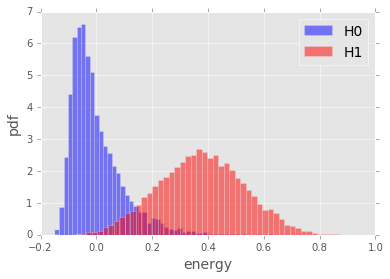

In [99]:
m, n = 10000, 5

mu0, mu1 = 0., 3.

def ene(xi, xj):
    # return 1./abs(xi-xj)
    return np.exp(-(xi-xj)*(xi-xj))

def total_ene(xas, xbs):
    ee = 0.
    na, nb = len(xas), len(xbs)
    eas, ebs, eabs = 0., 0., 0.
    for i in range(na):
        for j in range(i+1, na):
            eas += ene(xas[i], xas[j])
    for i in range(nb):
        for j in range(i+1, nb):
            ebs += ene(xbs[i], xbs[j])
    for i in range(na):
        for j in range(nb):
            eabs += ene(xas[i], xbs[j])
    ee = eas/(na*(na-1))+ebs/(nb*(nb-1))-eabs/(na*nb)
    return ee

def experiment():
    xas = stats.norm.rvs(loc=mu0, size=n)
    xbs = stats.norm.rvs(loc=mu1, size=n)
    return (xas, xbs)

dsets = [experiment() for i in range(m)]

enes0 = np.array([total_ene(dsets[i][0], dsets[m-1-i][0]) for i in range(m)])
enes1 = np.array([total_ene(iset[0], iset[1]) for iset in dsets])

fig, ax = plt.subplots()

# emin = np.min(np.min(enes0), np.min(enes1))
# emax = np.max(np.max(enes0), np.max(enes1))
ax.hist(enes0, bins=50, normed=True, range=(np.min(enes0), np.max(enes0)), color='blue', alpha=0.5, label='H0')
ax.hist(enes1, bins=50, normed=True, range=(np.min(enes1), np.max(enes1)), color='red', alpha=0.5, label='H1' )
ax.set_xlabel('energy', fontsize=14)
ax.set_ylabel('pdf', fontsize=14)
ax.legend(fontsize=14);

{\it Example} Let's consider an exponential decay with $\tau=1.$, generate $m$, large, number of experiment with a n-measurements of the $t$ r.v. Get $\hat{\tau}(t)$, and the distribution of $f(t(\tau)|\tau) = - 2 \log \lambda(\theta)$, and compare it with a $\chi^2_n(t(\tau)|n=1)$.



## Bibliography

[1] "Practical Statistic for LHC physicist," H. B. Prosper, CERN Academic Training Lectures (2015). https://indico.cern.ch/event/358542/ https://arxiv.org/pdf/1504.00945.pdf

[2] "Statistic for HEP," G. Cowan. CERN Academic Training Lectures (2012). http://indico.cern.ch/event/173726/

[3] "Statistics for Particle Physics," K. Cranmer, CERN Academic Training Lectures (2009). 
https://indico.cern.ch/event/48425/

[4] "Unified approach to the classical statistical analysis of small signals, "G. J. Feldman and R. D. Cousins, Phys. Rev. D57 (1998) 3873. http://journals.aps.org/prd/abstract/10.1103/PhysRevD.57.3873

[5] “Asymptotic formulae for likelihood-based tests of new physics,” Glen Cowan, Kyle Cranmer, Eilam Gross, Ofer Vitells. Eur. Phys. J. C71 1554 (2011). https://arxiv.org/abs/1007.1727

[6] "Incorporating systematic uncertainties into an upper limit," R.D. Cousins and V.L. Highland. Nucl. Instrum. Meth. A320, 331 (1992). http://www.sciencedirect.com/science/article/pii/0168900292907945

[7] "Confidence Level Computation for Combining Searches with Small Statistics," T. Junk, Nucl. Instrum. Meth. A434, 435 (1999). https://arxiv.org/abs/hep-ex/9902006  

[8] "How good are your fits? Unbinned multivariate goodness-of-fit tests in high energy physics.", M. Willians, arXiv:1006:3019. 

[9] ROOT https://root.cern.ch, TMVA http://tmva.sourceforge.net, RooFit https://root.cern.ch/roofit

[10] Anaconda https://anaconda.org, SciPy https://www.scipy.org, NumPy http://www.numpy.org, http://scikit-learn.org/stable/, http://matplotlib.org
